In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import graphviz
import torch_geometric
from torch_geometric.data import Dataset, Data, InMemoryDataset
from SALBP_solve import *
import os.path as osp
import ast
from sklearn.preprocessing import MinMaxScaler
import torchmetrics

In [2]:
!which  sklearn

/usr/bin/which: no sklearn in (/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/ipykernel/2023b/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/python/3.11.5/bin:/localscratch/jot240.42057029.0/bin:/home/jot240/R/x86_64-pc-linux-gnu-library/4.4/irace/bin:/home/jot240/.local/bin:/home/jot240/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/mii/1.1.2/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/flexiblascore/3.3.1/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcc12/openmpi/4.1.5/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/ucc/1.2.0/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/pmix/4.2.4/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gcccore/libfabric/1.18.0/bin:/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Compiler/gccco

In [3]:


class SALBDataset(InMemoryDataset):
    def __init__(self, root, edge_data_csv,alb_filepath, transform=None, pre_transform=None,raw_data_folder = "raw/small data set_n=20", cycle_time=1000):
        self.raw_data_folder = raw_data_folder
        self.alb_filepath = alb_filepath
        self.cycle_time = cycle_time
        self.edge_df = pd.read_csv(raw_data_folder + edge_data_csv)
        self.edge_df['alb_files'] = alb_filepath + '/'+ self.edge_df['instance']
        self.alb_files = self.edge_df['alb_files'].to_list()
        super().__init__(root, transform, pre_transform)

    @property
    def raw_dir(self):
        # Define your custom raw directory
        return osp.normpath( self.raw_data_folder)
    @property
    def processed_dir(self):
        # Define your custom processed directory
        return osp.join(self.root, 'processed/')

    @property
    def raw_file_names(self):
        # List files in `raw_dir` necessary for generating the dataset.
        return self.alb_files

    @property
    def processed_file_names(self):
        # List files in `processed_dir` that are already processed.
        processed_names = self.edge_df['instance'] + ".pt" 
        return processed_names.to_list()
    

    def download(self):
        # Logic for downloading raw data if it does not exist.
        pass

    def process(self):
        # Read raw data and save processed data to `processed_dir`.
        for index, row in self.edge_df.iterrows():
            print(f"Processing {row['instance']}...")
            # Example: Read graph data
            print("processing", row['alb_files'])
            salb_inst = parse_alb(row['alb_files'] + '.alb')
            edge_classes =  ast.literal_eval(row['is_less_max'])
            if len(edge_classes) != len(salb_inst['precedence_relations']):
                print("data mismatch on edges: " ,len(edge_classes), len(salb_inst['precedence_relations']))
                continue
            no_stations = ast.literal_eval(row['no_stations'])
            prec_relations = [(int(edge[0])-1,int(edge[1]) -1 ) for edge in salb_inst['precedence_relations']]
            edge_index = torch.tensor(prec_relations, dtype=torch.long)
            #loads task times as a value, but keeps it as a fraction of the cycle time
            x = torch.tensor([list(salb_inst['task_times'].values())], dtype=torch.float)/self.cycle_time
               # Properly shape the node features - this is important
            if x.dim() == 2 and x.size(0) == 1:
                # Transpose to get shape [num_nodes, 1]
                x = x.t()
            data = Data(x=x, edge_index=edge_index.t().contiguous())
            data.instance = row['instance']
            data.precendence_relation = ast.literal_eval(row['edge'])
            #print("number of nodes", self.num_nodes)
            
            data.edge_classes = torch.tensor(edge_classes, dtype =torch.bool)
            data.graph_class = bool(row['min_less_max'])
            data.n_stations = no_stations
            torch.save(data, self.processed_dir +row['instance'] + ".pt")

    def len(self):
        # Return the number of graphs in the dataset.
        return len(self.processed_file_names)

    def get(self, idx):
        # Load and return a graph object by index. NOTE: INDEXING STARTS AT 1 to stay consistent with Otto
        row  = self.edge_df.iloc[idx]
        data = torch.load( self.processed_dir +row['instance'] + ".pt")
        return data


my_dataset = SALBDataset(root='pytorch_datasets/medium',edge_data_csv ="medium_res_data_good_rows.csv",  alb_filepath=os.path.normpath("../../MALBPW/MMABPW/SALBP_benchmark/medium data set_n=50/"), raw_data_folder ="pytorch_datasets/medium/raw/")


In [4]:
my_dataset[22]

/tmp/ipykernel_3043467/1214504929.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


Data(x=[50, 1], edge_index=[2, 51], instance='instance_n=50_12', precendence_relation=[51], edge_classes=[51], graph_class=False, n_stations=[51])

In [5]:
#! rm -r pytorch_datasets/medium/processed/

In [6]:
my_dataset[3]

/tmp/ipykernel_3043467/1214504929.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


Data(x=[50, 1], edge_index=[2, 68], instance='instance_n=50_102', precendence_relation=[68], edge_classes=[68], graph_class=True, n_stations=[68])

In [7]:
print(my_dataset[0].x)

tensor([[0.0950],
        [0.1910],
        [0.1650],
        [0.1020],
        [0.0740],
        [0.1670],
        [0.1020],
        [0.1630],
        [0.2360],
        [0.2210],
        [0.1020],
        [0.0460],
        [0.0270],
        [0.1200],
        [0.0900],
        [0.3060],
        [0.0410],
        [0.0630],
        [0.0810],
        [0.1800],
        [0.2530],
        [0.0960],
        [0.1020],
        [0.2380],
        [0.1270],
        [0.1840],
        [0.1020],
        [0.1090],
        [0.0960],
        [0.1280],
        [0.1890],
        [0.0970],
        [0.2850],
        [0.0280],
        [0.1650],
        [0.1820],
        [0.2020],
        [0.0840],
        [0.0230],
        [0.1530],
        [0.0780],
        [0.1120],
        [0.0530],
        [0.1130],
        [0.1890],
        [0.0820],
        [0.2210],
        [0.0510],
        [0.0900],
        [0.2370]])


/tmp/ipykernel_3043467/1214504929.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


/tmp/ipykernel_3043467/1214504929.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


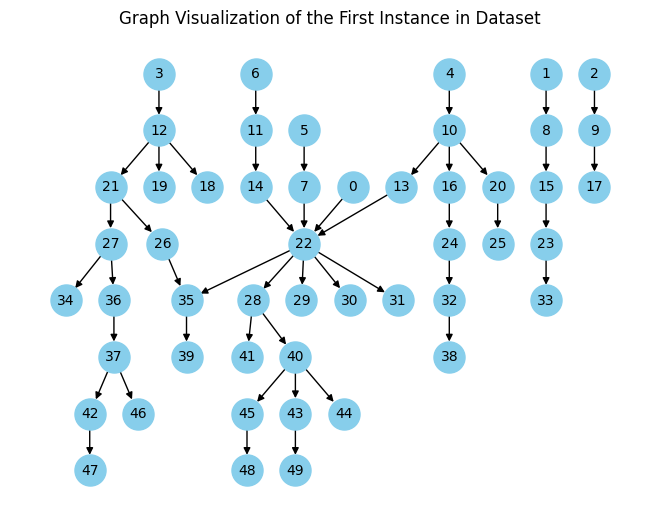

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming the first graph in my_dataset is at index 0
data = my_dataset[0]

# Create a NetworkX graph from the PyTorch Geometric Data object
graph = nx.DiGraph()
edge_index = data.edge_index.numpy()
#adds nodes
for j in range(data.x.shape[1]):
    graph.add_node(j)
#adds edges
for i in range(edge_index.shape[1]):
    graph.add_edge(edge_index[0, i], edge_index[1, i])

pos = nx.nx_pydot.graphviz_layout(graph, prog = "dot")

# Draw the graph, changes graph to graphviz and uses
nx.draw(graph, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", pos=pos)

plt.title("Graph Visualization of the First Instance in Dataset")
plt.show()

In [9]:


import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import global_mean_pool
from torch.utils.data import random_split

class EdgeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim=None):
        super(EdgeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # For edge features (if available)
        edge_input_dim = 2 * hidden_channels
#         if edge_dim is not None:
#             edge_input_dim += edge_dim
            
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(edge_input_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, out_channels)
        )
        
    def forward(self, x, edge_index, edge_attr=None):
        # Node embedding
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        # Edge embedding - gather node features for each edge
        parents, children = edge_index
        edge_features = torch.cat([x[parents], x[children]], dim=1)
        
        # # Combine with edge attributes if available
        # if edge_attr is not None:
        #     edge_features = torch.cat([edge_features, edge_attr], dim=1)
            
        # Edge classification
        return self.edge_mlp(edge_features)

In [10]:
# Get global statistics across all graphs
# def get_edge_label_stats(dataset):
#     all_labels = []
#     for data in dataset:
#         all_labels+=data.edge_classes
    
#     torch_labels = torch.tensor(all_labels, dtype=torch.bool)
#     counts = torch.bincount(torch_labels.int())
#     return counts

# # Calculate class weights
# class_counts= get_edge_label_stats(my_dataset)
# total_edges = class_counts.sum()
# class_weights = total_edges / (2 * class_counts)
# class_weights = torch.where(torch.isinf(class_weights), torch.tensor(0.0), class_weights)

# Count total positive and negative edges across all graphs
def get_pos_weight(data_list):
    num_pos = sum(data.edge_classes.sum().item() for data in data_list)
    num_neg = sum(len(data.edge_classes) - data.edge_classes.sum().item() for data in data_list)

    # Compute pos_weight for BCEWithLogitsLoss
    pos_weight = torch.tensor([num_neg / num_pos])  # Shape: (1,)
    return pos_weight
pos_weight = get_pos_weight(my_dataset)
#n_neg

/tmp/ipykernel_3043467/1214504929.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


In [11]:
from torch_geometric.loader import DataLoader


In [ ]:

# Hyperparameters
in_channels = 1 # Assuming a single feature per node.
hidden_channels = 64
out_channels = 1 # Number of classes for your classification task.
learning_rate = 0.01
epochs = 10000
batch_size = 5#TODO: Make it work for larger batch sizes
#splits the data into train and test
input_dataset = my_dataset.copy()
train_dataset, test_dataset = random_split(input_dataset, [int(len(input_dataset)*0.8), len(input_dataset) - int(len(input_dataset)*0.8)])
# train_dataset = [input_dataset[3]]
# test_dataset = [input_dataset[3]]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

accuracy = torchmetrics.Accuracy(task="binary")
precision = torchmetrics.Precision(task="binary")
recall = torchmetrics.Recall(task="binary")
f1_score = torchmetrics.F1Score(task="binary")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)
model = EdgeClassifier(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#loss_fn = torch.nn.BCEWithLogitsLoss()

criterion = nn.BCEWithLogitsLoss()
# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out.T, data.edge_classes.unsqueeze(dim=0).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    # Evaluation
    model.eval()
    #  Testing loop
    with torch.no_grad():
      total_loss = 0
      for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index)
        loss = loss_fn(out.T, data.edge_classes.unsqueeze(dim=0).float())
        probs = torch.sigmoid(out)
        print("average probability", probs.squeeze(1).float().mean())
        # Set a threshold to convert probabilities to binary predictions
        threshold = 0.5
        targets = data.edge_classes
        preds = (probs > threshold).int().squeeze(1)
        acc = accuracy(preds, targets)
        prec = precision(preds, targets)
        rec = recall(preds, targets)
        f1 = f1_score(preds, targets)

        #correct = (predictions.squeeze(1) == data.edge_classes)  # Per-class correct predictions
        # print(correct)
        
        
        # Overall accuracy
        #overall_accuracy = (predictions.squeeze(1) == data.edge_classes).float().mean()

        # Print metrics

        #print(f"Correct: {correct.tolist()}")
        #print(f"Overall accuracy: {overall_accuracy.item()}")
        
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")


/tmp/ipykernel_3043467/1214504929.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


using device: cpu
Epoch 1, Loss: 1.3092185961666392
average probability tensor(0.4668)
Accuracy: 0.9079, Precision: 0.1200, Recall: 0.1364, F1 Score: 0.1277
average probability tensor(0.4802)
Accuracy: 0.8857, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.4462)
Accuracy: 0.9665, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.4519)
Accuracy: 0.9642, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.4686)
Accuracy: 0.9388, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.4561)
Accuracy: 0.9715, Precision: 0.3333, Recall: 0.0909, F1 Score: 0.1429
average probability tensor(0.4594)
Accuracy: 0.9545, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.4680)
Accuracy: 0.6877, Precision: 0.1290, Recall: 0.0396, F1 Score: 0.0606
average probability tensor(0.4677)
Accuracy: 0.9332, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
ave